# LoMST for Unsupervised Anomaly Detection

References:
I. Ahmed, A. Dagnino and Y. Ding, "Unsupervised Anomaly Detection Based on Minimum Spanning Tree Approximated Distance Measures and its Application to Hydropower Turbines," in *IEEE Transactions on Automation Science and Engineering*, vol. 16, no. 2, pp. 654-667, April 2019, doi: 10.1109/TASE.2018.2848198.

Implementing the model from the referenced paper in Python. A local minimum spanning tree is used to approximate distances of points where Euclidean distances may not be appropriate for multivariate data due to a manifold. This distance is used to isolate points of greater distances with an outlier score.

The paper can be found on the IEEE website. The data and R code for the paper can be found [here](https://zenodo.org/records/5525295). 

### Imports

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy import sparse

### Data processing
The data supplied already has duplicates, recording errors, and rows with missing data removed.

In [234]:
hydro_df = pd.read_csv('Hydropower.csv', parse_dates=['Date']).set_index('Date')  # Read csv, parse date
hydro_df.iloc[:,:10].sample(10)

,BD000fP_Air,BD000fT_Air_G,BD010fT_SOD,BD011fP_InPip,BD011fR_DistrPos,BD011fT_GBmet,BD011fT_GBmetA,BD011fT_GBoil,BD011fT_GBoilA,BD011fT_TBmet
Date,,,,,,,,,,
2015-10-14 12:25:00,955.815979,18.110933,22.032501,93.740364,99.328949,34.673843,16.562910,38.919662,20.808729,29.386581
2015-07-03 11:30:00,973.355469,28.258183,29.578857,97.980476,22.176497,41.611359,13.353176,45.168228,16.910045,37.413589
2015-07-08 14:40:00,958.807495,30.066378,32.014191,98.042717,20.915113,43.037308,12.970930,46.433960,16.367582,38.679337
2015-10-05 08:40:00,966.140991,16.945145,21.503784,96.449257,50.324841,33.424118,16.478973,38.503098,21.557953,31.437393
2015-07-05 21:20:00,968.056763,29.953461,34.305328,97.915741,23.198483,44.110779,14.157318,47.235062,17.281601,39.720764
2015-09-16 21:20:00,959.599426,22.172884,26.967270,96.449257,49.674339,35.923553,13.750669,41.050583,18.877699,33.456161
2015-07-12 05:10:00,966.367615,24.988174,28.184937,98.042717,18.187618,41.306931,16.318757,44.110779,19.122605,37.221329
2016-01-06 16:00:00,949.111938,12.149284,16.345764,97.427574,33.343872,31.752502,19.603218,36.335312,24.186028,28.975357
2016-03-19 13:50:00,963.171204,16.877953,20.183029,95.333748,56.917995,31.476383,14.598430,36.865112,19.987159,28.941711


In [235]:
def LoMST(data_df, selectedk=15):
    data = data_df.copy()
    
    # Get indices of nearest neighbors
    knn_model = NearestNeighbors(n_neighbors=selectedk+1)  # n neighbors different between R/Python
    knn_model.fit(data)
    distances, indices = knn_model.kneighbors(data)
    kn = np.array(indices)
    kn = kn[:, 1:]
    zeros = np.zeros((kn.shape[0],1), dtype=int)  # Add a column of zeros to kn
    kn = np.hstack((zeros,kn))
    
    # Calculate distance between neighbors
    dist_matrix_dict = {}
    for i in range(len(data)):
        pairwise_distances = pdist(data.iloc[kn[i,]])
        dist_matrix_dict[i] = squareform(pairwise_distances)
        
    # Calculate MST
    sumhist = np.zeros(len(data))
    compare = np.zeros(len(data))
    for i in range(len(data)):
        sparse_mat = sparse.csr_matrix(dist_matrix_dict[i])
        d = minimum_spanning_tree(sparse_mat).todense()
        d = np.where(d > 0.0, 1, 0)
        d = d + d.T  # Python MST doesn't return a symmetric matrix like R
        dist_matrix_dict[i][np.where(d == 0)] = 0
        sumhist[i] = np.sum(dist_matrix_dict[i])
    
    # Calculate Outlier score
    for i in range(len(data)):
        compare[i] = sumhist[i] - np.mean(sumhist[kn[i,]])
        
    summary = pd.DataFrame({'compare': compare})
    summary['obs'] = range(len(data))  # Add a column 'obs' with row numbers
    data['obs'] = range(len(data))
    
    final = pd.merge(summary, data, on='obs')
    final = final[['compare']]
    
    final['Outlier_Score'] = (final['compare'] - final['compare'].min()) / (final['compare'].max() - final['compare'].min())
    final.index = data.index
    
    return final #.sort_values(by='compare', ascending=False)

In [236]:
# The paper uses an average of 10, 15, and 20 neighbors
multk = pd.concat([LoMST(hydro_df, selectedk=10)['compare'],LoMST(hydro_df, selectedk=15)['compare'], LoMST(hydro_df, selectedk=20)['compare']], axis=1)

multk['avg'] = multk.mean(axis=1)

In [237]:
multk[['avg']].sort_values(by='avg', ascending=False)

,avg
Date,
2016-01-12 11:20:00,237.514440
2015-09-14 13:30:00,176.801088
2016-01-11 11:50:00,176.549147
2015-09-14 13:50:00,170.168043
2016-01-09 18:40:00,169.302347
...,...
2015-04-15 17:10:00,-12.313455
2015-04-16 04:10:00,-12.460770
2015-10-17 04:05:00,-13.561409


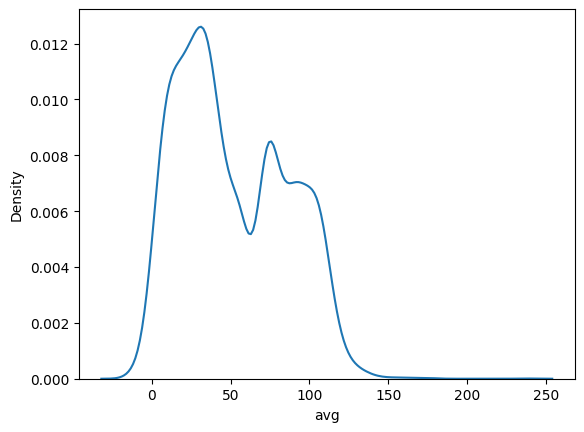

In [238]:
import seaborn as sns
sns.kdeplot(multk['avg']);

The paper selected the number of neighbors based on domain knowledge. If not known, the outlier score should stabilize for a range of values. It is believed that this means that number of neighbors works well for the manifold. So, the heuristic is to calculate the average outlier score over a range of values and to select a k in the first stable range.

The code is commented out because it takes a minute to run, but the output is saved.

In [239]:
# k_opt = np.zeros((2, 59))
# for i in range(1,60):
#     k_opt[0, i-1] = i+1
#     res = LoMST(hydro_df, selectedk=i)
#     k_opt[1, i-1] = res['Outlier_Score'].mean()
# 
# plt.title("Average LoMST Outlier Score by k")
# plt.xlabel("Number of Neighbors (k)")
# plt.plot(k_opt[0], k_opt[1],'.');

![alt text](kmean.png "Title")

Based on this, I would have gone with a k in the 30s.

In [240]:
lmst_df = LoMST(hydro_df, selectedk=33)
lmst_df.sort_values(by='Outlier_Score', ascending=False).head(10)

,compare,Outlier_Score
Date,,
2015-09-14 09:50:00,426.221620,1.000000
2016-01-12 11:20:00,219.599041,0.564701
2015-09-14 13:30:00,207.537855,0.539292
2015-07-04 05:10:00,203.830581,0.531481
2016-01-09 08:30:00,199.298536,0.521934
2015-09-15 20:20:00,197.421722,0.517980
2015-07-04 04:50:00,188.416606,0.499008
2015-09-14 14:10:00,187.323386,0.496705
2015-09-15 22:20:00,186.611554,0.495205


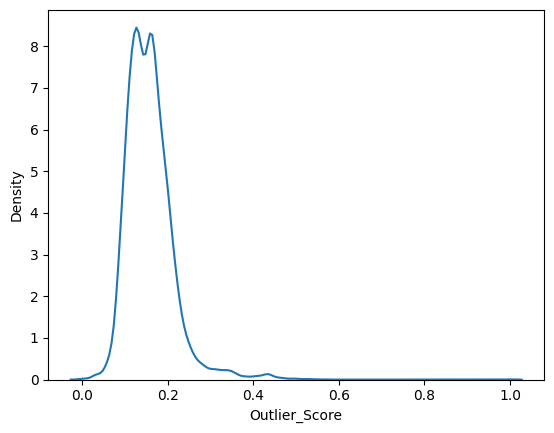

In [241]:
import seaborn as sns
sns.kdeplot(lmst_df['Outlier_Score']);